## Imports

In [1]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Read Image Data

In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
#Set data directory
data_dir = pathlib.Path('./data')

In [4]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


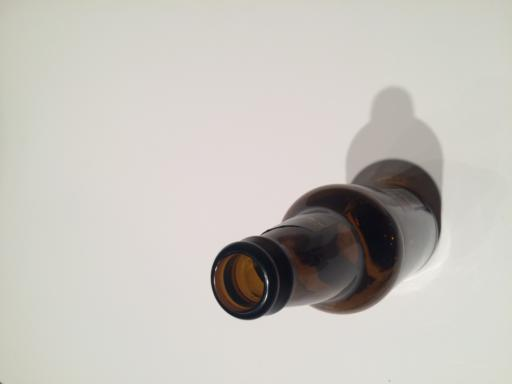

In [5]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

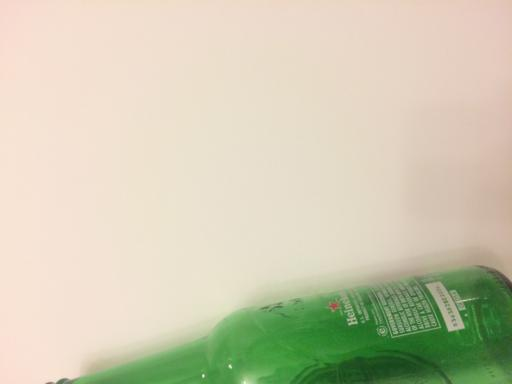

In [6]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [7]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [8]:
# #clear images folder
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [9]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


In [10]:
#Show names of the found classes
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Configure the dataset

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [11]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.078431375 1.0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define Model

In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ]
)

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=8
)

Epoch 1/8
64/64 [==============================] - 218s 3s/step - loss: 1.6175 - accuracy: 0.3314 - val_loss: 1.4202 - val_accuracy: 0.4303
Epoch 2/8
64/64 [==============================] - 197s 3s/step - loss: 1.2924 - accuracy: 0.4963 - val_loss: 1.2024 - val_accuracy: 0.5179
Epoch 3/8
64/64 [==============================] - 191s 3s/step - loss: 1.0552 - accuracy: 0.6013 - val_loss: 1.1900 - val_accuracy: 0.5817
Epoch 4/8
64/64 [==============================] - 198s 3s/step - loss: 0.8945 - accuracy: 0.6677 - val_loss: 1.2164 - val_accuracy: 0.5976
Epoch 5/8
64/64 [==============================] - 199s 3s/step - loss: 0.7601 - accuracy: 0.7271 - val_loss: 1.2590 - val_accuracy: 0.6215
Epoch 6/8
64/64 [==============================] - 203s 3s/step - loss: 0.5363 - accuracy: 0.8063 - val_loss: 1.3135 - val_accuracy: 0.5976
Epoch 7/8
64/64 [==============================] - 233s 4s/step - loss: 0.3877 - accuracy: 0.8638 - val_loss: 1.4345 - val_accuracy: 0.6096
Epoch 8/8
64/64 [===

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 384, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 128, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 128, 32)       1

In [ ]:
date = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")

In [32]:
# save as tlite model 
# Convert the model.
convert_model = True

if convert_model:       
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\MAXIMI~1\AppData\Local\Temp\tmpmx_6peil\assets


INFO:tensorflow:Assets written to: C:\Users\MAXIMI~1\AppData\Local\Temp\tmpmx_6peil\assets


In [29]:
# save model
save_model = True
if save_model:      
      model.save(f'./models/model_{date}')

INFO:tensorflow:Assets written to: ./models/model_2023-02-23_20-57-42\assets


INFO:tensorflow:Assets written to: ./models/model_2023-02-23_20-57-42\assets


In [30]:
#export training history
save = False

if save:
    np.save('test2_history.npy',history.history)

In [33]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

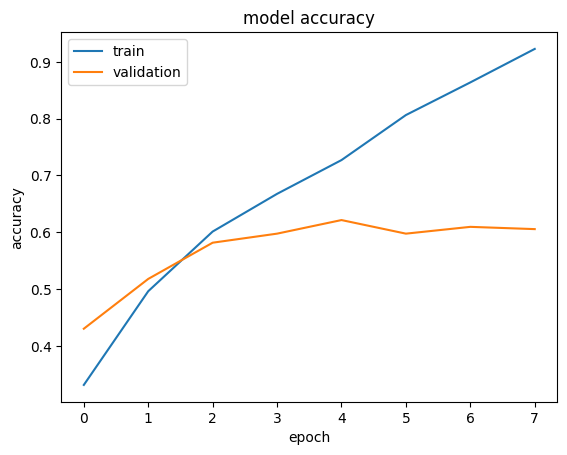

In [34]:
def plot_history_acc(history):
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_acc.png')
    
plot_history_acc(history)


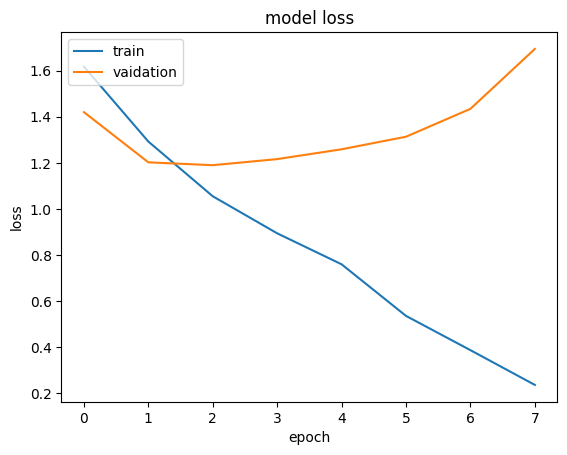

In [35]:
def plot_history_loss(history):
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_loss.png')
    
plot_history_loss(history)

Predictions:
 [1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1
 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0
 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 1 0]
Labels:
 [0 0 0 3 4 3 0 0 3 2 4 1 3 2 4 2 2 5 3 2 2 2 4 0 3 3 1 1 4 1 4 2]


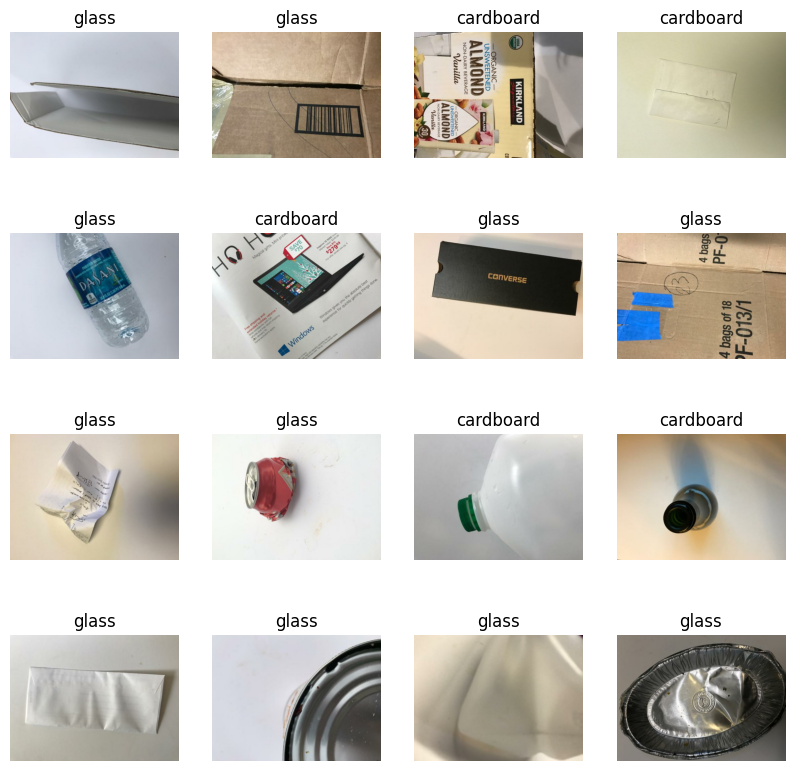

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [36]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [37]:
# i = 0
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels, test_images)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  test_labels)
# plt.show()

In [38]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)